In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
from glob import glob
import pydicom
import tensorflow as tf
import tqdm as tqdm
import tensorflow_io as tfio
import pathlib
import datetime
# tensorboard
%load_ext tensorboard
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

"""
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
"""
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

"\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n"

In [2]:
!pip install pylibjpeg
!pip install python_gdcm
!pip install pylibjpeg_libjpeg

In [3]:
import pylibjpeg
import gdcm
import libjpeg

# Creating the Dataset tf.Dataset.from_tensor_slices #

In [4]:
class cl_CreatingDataset:
    def __init__(self, imageHeight, imageWidth, batch_size):
        self.imageHeight = imageHeight
        self.imageWidth = imageWidth
        self.batch_size = batch_size

    
    def creatingPathList(self, trainImagesPath, trainDfPath):
        trainDf = pd.read_csv(trainDfPath)
        trainImagesPathList = []
        labels = []
        # reading the tain CSV
        trainDf = pd.read_csv(trainDfPath)
        for i in tqdm.tqdm(range(len(trainDf))):
            folderName = trainDf["StudyInstanceUID"].iloc[i]
            imageFolderPath = os.path.join(trainImagesPath, folderName)
            for file in glob(os.path.join(imageFolderPath, "*.dcm")):
                # taking the imageName
                trainImagesPathList.append(file)
                # creating the labels
                label = np.array([trainDf["C1"].iloc[i],trainDf["C2"].iloc[i], trainDf["C3"].iloc[i], trainDf["C4"].iloc[i], trainDf["C5"].iloc[i], 
                                 trainDf["C6"].iloc[i], trainDf["C7"].iloc[i], trainDf["patient_overall"].iloc[i]])
                labels.append(label)
        
        return trainImagesPathList, labels
    
    def parse_function(self, filename, label):
        image_bytes = tf.io.read_file(filename)
        image = tfio.image.decode_dicom_image(image_bytes, dtype=tf.float32)
        #image = tf.image.convert_image_dtype(image, tf.float32)
        resized_image = tf.image.resize(image, [self.imageHeight, self.imageWidth])
        compressedImage = tf.squeeze(resized_image, axis = 0)
        finalImage = tf.repeat(compressedImage, repeats=[3], axis = 2)
        return finalImage, label
        
    def train_preprocess(self, image, label):
        return image, label


    def creatingDataset(self, filenames, labels):
        dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
        dataset = dataset.shuffle(len(filenames))
        dataset = dataset.map(self.parse_function, num_parallel_calls=4)
        dataset = dataset.map(self.train_preprocess, num_parallel_calls=4)
        dataset = dataset.batch(self.batch_size)
        dataset = dataset.prefetch(1)

        return dataset

# Creating Dataset using Generator Concept (tf.data.Dataset.fromgenerator) #

In [5]:
DATA_DIR = "../input/rsna-2022-cervical-spine-fracture-detection/"
trainCsv = "../input/rsna-2022-cervical-spine-fracture-detection/train.csv"
train_df = pd.read_csv(trainCsv)
print(train_df.head())

            StudyInstanceUID  patient_overall  C1  C2  C3  C4  C5  C6  C7
0   1.2.826.0.1.3680043.6200                1   1   1   0   0   0   0   0
1  1.2.826.0.1.3680043.27262                1   0   1   0   0   0   0   0
2  1.2.826.0.1.3680043.21561                1   0   1   0   0   0   0   0
3  1.2.826.0.1.3680043.12351                0   0   0   0   0   0   0   0
4   1.2.826.0.1.3680043.1363                1   0   0   0   0   1   0   0


In [6]:
def load_dicom(path):
    """
    reads a dicom file and loads the image array inside it
    inputs:
        path: the path of the required dicom file
    returns:
        data: image pixel arrays
    """
    img=pydicom.dcmread(path)
    data=img.pixel_array
    data=data-np.min(data)
    if np.max(data) != 0:
        data=data/np.max(data)
    data=(data*255).astype(np.uint8)
    return data

In [7]:
def data_generator():
    for i, study_instance in enumerate(train_df.StudyInstanceUID[:]):
        for dcm in os.listdir(DATA_DIR + f"train_images/{study_instance}"):
            train_labels = []
            path = DATA_DIR + f"train_images/{study_instance}/{dcm}"
            img = load_dicom(path)
            
            # resize each image into a shape of (512, 512)
            img = np.resize(img, (512, 512))
            #  normalize image
            img = img / 255.0
            # convert from gray scale to rgb, this will be helpful incase we want to use pretrained models
            img = tf.expand_dims(img, axis=-1)
            img = tf.image.grayscale_to_rgb(img)
            
            train_labels.extend([
                train_df.loc[i, "C1"],
                train_df.loc[i, "C2"],
                train_df.loc[i, "C3"],
                train_df.loc[i, "C4"],
                train_df.loc[i, "C5"],
                train_df.loc[i, "C6"],
                train_df.loc[i, "C7"],
                train_df.loc[i, "patient_overall"] # end with patient overall
            ])
            yield img, train_labels

## Splitting and Preparing the dataset

In [8]:
# here it refers to tf.dataset
def splitDataset(dataset, trainFactor, testFactor, img_count):
    train_dataset = dataset.take(int(trainFactor * img_count))
    validation_dataset = dataset.take(int((1 - (trainFactor+testFactor))* img_count))
    test_dataset = dataset.take(int(testFactor * img_count))
    
    return train_dataset, validation_dataset, test_dataset
    

In [9]:
def configure_for_performance(data):
    data = data.cache()
    data = data.batch(16)
    data = data.prefetch(buffer_size=tf.data.AUTOTUNE)
    return data

In [10]:
# this is required because of length of dataset is not valid for generators
def getImageCount():
    
    # start at 285 because indexing to 5 only returns 1744 image counts
    img_count = 285
    for _, study_instance in enumerate(train_df.StudyInstanceUID[:5]):
        for _ in os.listdir(DATA_DIR + f"train_images/{study_instance}"):
            img_count += 1
            
    return img_count

In [11]:
# prepare dataset for training
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
# creating the dataset
dataset = tf.data.Dataset.from_generator(data_generator, (tf.float32, tf.int8))

# printing a sample data for checking
for img, label in dataset.take(1):
    print(img.shape)
    print(label.shape)
    print(label)

# splitting the dataset
trainFactor = 0.8
testFactor = 0.0025
img_count = getImageCount()
print("[***] Images for training, testing and validation : ", img_count)
train_data, validation_data, test_data = splitDataset(dataset, trainFactor,testFactor, img_count)
#
train_dataset = configure_for_performance(train_data)
validation_dataset = configure_for_performance(validation_data)
test_dataset = configure_for_performance(test_data)

(512, 512, 3)
(8,)
tf.Tensor([1 1 0 0 0 0 0 1], shape=(8,), dtype=int8)
[***] Images for training, testing and validation :  2019


## Creating the models 
We create 4 models: a basic cnn, and three transfer learning pretrained CNNs - VGG16, ResNet50 and EfficientNetB5. All of them are available through Keras. Each of them has a pro and con that make their use-case and accuracy vary.

In [12]:
!pip install keras_metrics

In [13]:
# model modules and libraries
from tensorflow import keras
from tensorflow.keras import layers, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten,Dense, InputLayer, BatchNormalization, Dropout, GlobalAveragePooling2D
from keras_metrics import f1_score

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications.efficientnet import EfficientNetB5, preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.python.keras.wrappers.scikit_learn import KerasClassifier

In [14]:
# common inputs across all models
IMG_SHAPE = (512, 512, 3)

# max the loss during training
# training will be stopped after 5 epochs with no improvement
early_stop = keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                               patience=8,
                                               verbose=1,
                                               mode="max",
                                               restore_best_weights=True)

In [15]:
def basic_cnn_model(img_shape):
    '''
    Function to create basic CNN model with multilple Convolutional and Neural layers 
    '''
    
    # build a sequential model 
    model = Sequential()
    model.add(InputLayer(input_shape=(img_shape)))

    # 1st conv block
    model.add(Conv2D(25, (5, 5), activation='relu', strides=(1, 1), padding='same'))
    model.add(MaxPool2D(pool_size=(2, 2), padding='same'))

    # 2nd conv block
    model.add(Conv2D(50, (5, 5), activation='relu', strides=(2, 2), padding='same'))
    model.add(MaxPool2D(pool_size=(2, 2), padding='same'))
    model.add(BatchNormalization())

    # 3rd conv block
    model.add(Conv2D(70, (3, 3), activation='relu', strides=(2, 2), padding='same'))
    model.add(MaxPool2D(pool_size=(2, 2), padding='valid'))
    model.add(BatchNormalization())

    # ANN block
    model.add(Flatten())
    model.add(Dense(units=100, activation='relu'))
    model.add(Dense(units=100, activation='relu'))
    model.add(Dropout(0.25))
    # output layer
    model.add(Dense(units=8, activation='sigmoid'))
    return model

In [16]:
def create_resnet_model(img_shape):
    
    inputs = Input(shape=img_shape)
    base_model = ResNet50(input_tensor=inputs,
                        include_top=False,
                        weights='imagenet')
    # freeze base layer
    base_model.trainable = False
    
    # freeze all the lower level layers
    for layer in base_model.layers[:len(base_model.layers)]:
        layer.trainable = False
    
    # build a sequential model and add base model to it
    model = Sequential()
    model.add(base_model)
    model.add(Flatten())
    
    # output layer
    model.add(Dense(8, activation = 'sigmoid'))

    return model

In [17]:
def create_efficientnet_model(img_shape):
    # base efficientnet model with ImageNet weights and top layer not included
    base_model = tf.keras.applications.EfficientNetB5(input_shape=img_shape,
                                               include_top=False,
                                               weights='imagenet')
    
    # freeze base layer and define input shape
    base_model.trainable = False
    inputs = Input(shape=img_shape)
    x = base_model(inputs)
    
    # add pooling and dropout
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.2)(x)
    
    # output model, and complete model
    outputs = Dense(8, activation = 'sigmoid')(x)
    model = tf.keras.Model(inputs, outputs)
    return model

In [18]:
def create_inception_model(img_shape):
    
    # base inceptionv3 architecture
    base_model = InceptionV3(include_top=False, 
                             weights='imagenet',
                            input_shape=(img_shape))
    
    # freeze model
    base_model.trainable = False

    # add sequenctial model to base model then add pooling and dropout
    add_model = Sequential()
    add_model.add(base_model)
    add_model.add(GlobalAveragePooling2D())
    add_model.add(Dropout(0.5))
    
    # output layer
    add_model.add(Dense(8, activation='sigmoid'))
    return add_model


trainCsv = "../input/rsna-2022-cervical-spine-fracture-detection/train.csv"
trainImagePath = "../input/rsna-2022-cervical-spine-fracture-detection/train_images"
creDataset = cl_CreatingDataset(224, 224, 4)
trainImagesPathList, labels = creDataset.creatingPathList(trainImagePath, trainCsv)
print("train Image list :", len(trainImagePath), ".....", "train label list : ", len(labels))


## Callbacks ##

In [19]:
def createTensorboardCallback(logdir):
    return tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)

    
def saveModelCallback(filePath):
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=filePath, monitor='val_loss',verbose=1, save_best_only=True, mode='min')
    
    return checkpoint


In [20]:
# common model parameters
INIT_LR = 1e-3
opt = tf.keras.optimizers.Adam(learning_rate=INIT_LR)

# training
EPOCHS = 10
BATCH_SIZE = 4

In [22]:
# create and ccompile model
cnn_model = basic_cnn_model(IMG_SHAPE)
cnn_model.summary()

cnn_model.compile(loss='binary_crossentropy',
              optimizer="adam", 
              metrics=['binary_accuracy', 'AUC', f1_score()])

# tensorboard logging dir
foldername = "/kaggle/working/basicnn/tensorboardRecord"
os.makedirs(foldername, exist_ok=True)
logdir = os.path.join(foldername, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))


# modelsave checkpoint
modelDir = "/kaggle/working/basicnn/modelDir"
os.makedirs(modelDir, exist_ok=True)
filepath = 'my_best_model.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5'
modelSavePath = os.path.join(modelDir, filepath)

tensorboardCallback = createTensorboardCallback(logdir)
modeSaveCallback = saveModelCallback(modelSavePath)

# fit on data for 30 epochs
basic_cnn = cnn_model.fit(train_dataset, epochs=EPOCHS, 
                      validation_data=validation_dataset, batch_size=BATCH_SIZE,
                      callbacks=[modeSaveCallback, early_stop])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 512, 512, 25)      1900      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 256, 256, 25)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 50)      31300     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 50)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 50)        200       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 70)        31570     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 70)        0

/opt/conda/lib/python3.7/site-packages/keras/engine/base_layer.py:1348: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


101/101 [==============================] - 63s 532ms/step - loss: 0.3207 - binary_accuracy: 0.9461 - auc: 0.9699 - f1_score: 0.8112 - val_loss: 1.0225 - val_binary_accuracy: 0.6778 - val_auc: 0.8526 - val_f1_score: 0.6037

Epoch 00001: val_loss improved from inf to 1.02254, saving model to /kaggle/working/basicnn/modelDir/my_best_model.epoch01-loss1.02.hdf5
Epoch 2/10
101/101 [==============================] - 8s 81ms/step - loss: 0.1957 - binary_accuracy: 0.9747 - auc: 0.9714 - f1_score: 0.6397 - val_loss: 2.9800 - val_binary_accuracy: 0.6737 - val_auc: 0.6068 - val_f1_score: 0.5706

Epoch 00002: val_loss did not improve from 1.02254
Epoch 3/10
101/101 [==============================] - 8s 81ms/step - loss: 0.3854 - binary_accuracy: 0.9614 - auc: 0.9638 - f1_score: 0.5826 - val_loss: 2.0460 - val_binary_accuracy: 0.7748 - val_auc: 0.7806 - val_f1_score: 0.5407

Epoch 00003: val_loss did not improve from 1.02254
Epoch 4/10
101/101 [==============================] - 8s 80ms/step - loss:

In [43]:
# compile resnet model 
resnet_model = create_resnet_model(IMG_SHAPE)
resnet_model.compile(optimizer="adam",
                      loss="binary_crossentropy",
                      metrics=['binary_accuracy', 'AUC', f1_score()])

resnet_model.summary()

# tensorboard logging dir
foldername = "/kaggle/working/resnet/tensorboardRecord"
os.makedirs(foldername, exist_ok=True)
logdir = os.path.join(foldername, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))


# modelsave checkpoint
modelDir = "/kaggle/working/resnet/modelDir"
os.makedirs(modelDir, exist_ok=True)
filepath = 'my_best_model.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5'
modelSavePath = os.path.join(modelDir, filepath)

tensorboardCallback = createTensorboardCallback(logdir)
modeSaveCallback = saveModelCallback(modelSavePath)


#freeze model
# resnet_model.trainable=False
resnet_final = resnet_model.fit(x=train_dataset,y=None, epochs=EPOCHS, 
                      validation_data=validation_dataset, batch_size=BATCH_SIZE,
                      callbacks=[modeSaveCallback, early_stop])

94781440/94765736 [==============================] - 2s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 16, 16, 2048)      23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 524288)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 4194312   
Total params: 27,782,024
Trainable params: 4,194,312
Non-trainable params: 23,587,712
_________________________________________________________________
Epoch 1/10


/opt/conda/lib/python3.7/site-packages/keras/engine/base_layer.py:1348: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


101/101 [==============================] - 26s 215ms/step - loss: 3.0028 - binary_accuracy: 0.8002 - auc: 0.8639 - f1_score: 0.5075 - val_loss: 0.7423 - val_binary_accuracy: 0.9513 - val_auc: 0.9639 - val_f1_score: 0.3572

Epoch 00001: val_loss improved from inf to 0.74235, saving model to /kaggle/working/resnet/modelDir/my_best_model.epoch01-loss0.74.hdf5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/10
101/101 [==============================] - 19s 192ms/step - loss: 2.9919 - binary_accuracy: 0.8039 - auc: 0.8664 - f1_score: 0.4002 - val_loss: 0.7423 - val_binary_accuracy: 0.9513 - val_auc: 0.9639 - val_f1_score: 0.3749

Epoch 00002: val_loss did not improve from 0.74235
Epoch 3/10
101/101 [==============================] - 19s 191ms/step - loss: 2.9919 - binary_accuracy: 0.8039 - auc: 0.8664 - f1_score: 0.3942 - val_loss: 0.7423 - val_binary_accuracy: 0.9513 - val_auc: 0.9639 - val_f1_score: 0.3799

Epoch 00003: val_loss did not improve from 0.74235
Epoch 4/10
101/101 [==============================] - 19s 191ms/step - loss: 2.9919 - binary_accuracy: 0.8039 - auc: 0.8664 - f1_score: 0.3923 - val_loss: 0.7423 - val_binary_accuracy: 0.9513 - val_auc: 0.9639 - val_f1_score: 0.3823

Epoch 00004: val_loss did not improve from 0.74235
Epoch 5/10
101/101 [==============================] - 19s 191ms/step - loss: 2.9919 - binary_accuracy: 0.8039 - auc: 0.8664 - f1_score: 0.3914 - 

In [44]:
# creating and compiling efficientnet  model
inception_model = create_inception_model(IMG_SHAPE)

# Checking Model Summary
inception_model.compile(optimizer=opt, loss=tf.keras.losses.BinaryCrossentropy()
              , metrics=['binary_accuracy', 'AUC', f1_score()])
inception_model.summary()

# tensorboard logging dir
foldername = "/kaggle/working/inception/tensorboardRecord"
os.makedirs(foldername, exist_ok=True)
logdir = os.path.join(foldername, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))


# modelsave checkpoint
modelDir = "/kaggle/working/inception/modelDir"
os.makedirs(modelDir, exist_ok=True)
filepath = 'my_best_model.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5'
modelSavePath = os.path.join(modelDir, filepath)

tensorboardCallback = createTensorboardCallback(logdir)
modeSaveCallback = saveModelCallback(modelSavePath)

# fit the dataa and train model
inception_final = inception_model.fit(x=train_dataset, y=None, batch_size = BATCH_SIZE,
                                epochs = EPOCHS, validation_data = validation_dataset,
                                    callbacks=[modeSaveCallback,early_stop])

87924736/87910968 [==============================] - 2s 0us/step
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 14, 14, 2048)      21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 16392     
Total params: 21,819,176
Trainable params: 16,392
Non-trainable params: 21,802,784
_________________________________________________________________
Epoch 1/10
101/101 [==============================] - 23s 181ms/step - loss: 0.2826 - binary_accuracy: 0.9330 - auc: 0.9495 - f1_score: 0.6862 - val_loss: 1.9731 - val_bi

In [45]:
# creating and compiling efficientnet  model
effnet_model = create_efficientnet_model(IMG_SHAPE)
#model = alex_net()
effnet_model.summary()
effnet_model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['binary_accuracy', 'AUC', f1_score()])

# tensorboard logging dir
foldername = "/kaggle/working/effnet/tensorboardRecord"
os.makedirs(foldername, exist_ok=True)
logdir = os.path.join(foldername, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))


# modelsave checkpoint
modelDir = "/kaggle/working/effnet/modelDir"
os.makedirs(modelDir, exist_ok=True)
filepath = 'my_best_model.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5'
modelSavePath = os.path.join(modelDir, filepath)

tensorboardCallback = createTensorboardCallback(logdir)
modeSaveCallback = saveModelCallback(modelSavePath)

# fit the dataa and train model
effnet_final = effnet_model.fit(x=train_dataset, y=None, batch_size = BATCH_SIZE,
                                epochs = EPOCHS, validation_data = validation_dataset,
                                callbacks=[modeSaveCallback, early_stop])

115277824/115263384 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
efficientnetb5 (Functional)  (None, 16, 16, 2048)      28513527  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 16392     
Total params: 28,529,919
Trainable params: 16,392
Non-trainable params: 28,513,527
_________________________________________________________________
Epoch 1/10
101/101 [=======================

## Displaying the training graphs ##

In [46]:
def display(history, model_name):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    plt.suptitle(f"Metrics for {model_name}", size =15)
    # accuracy summary 
    ax[0].plot(history.history['binary_accuracy'])
    ax[0].plot(history.history['val_binary_accuracy'])
    ax[0].set_title('model accuracy')
    ax[0].set_ylabel('accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].legend(['train', 'test'], loc='upper left')
    
    # loss history summary
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('model loss')
    ax[1].set_ylabel('loss')
    ax[1].set_xlabel('epoch')
    ax[1].legend(['train', 'test'], loc='upper left')
    plt.show()

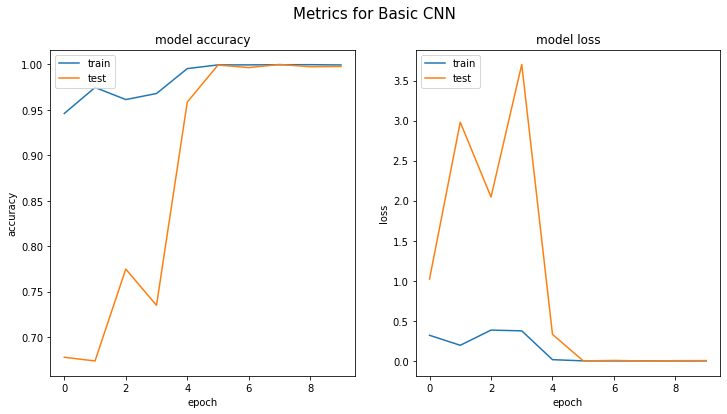

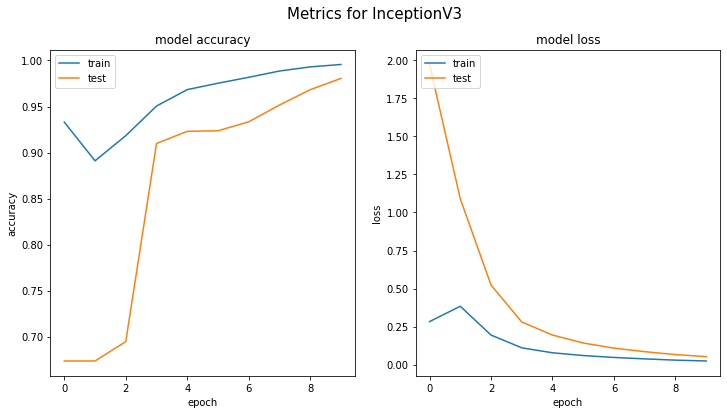

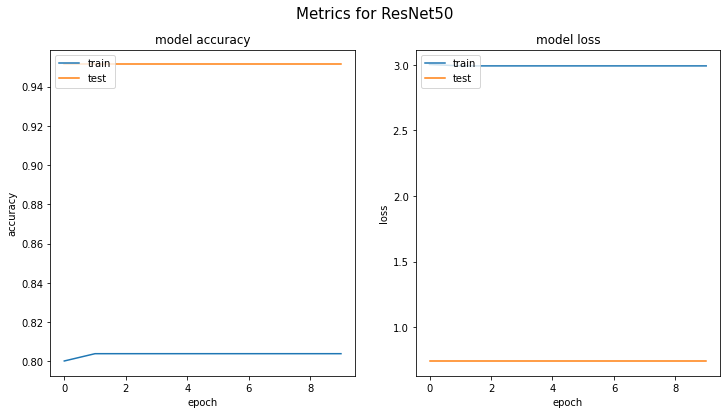

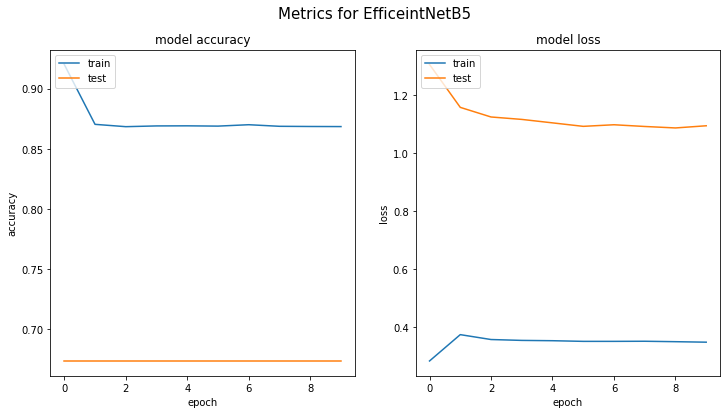

In [47]:
import matplotlib.pyplot as plt
display(basic_cnn, 'Basic CNN')
display(inception_final, 'InceptionV3')
display(resnet_final, 'ResNet50')
display(effnet_final, 'EfficeintNetB5')

## Model Inference

In [30]:
# inference with best performing model
inference_model = cnn_model
inference_model.summary()
results = inference_model.evaluate(test_dataset, batch_size=16)
print("Evaluation on test data")
print(results)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 512, 512, 25)      1900      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 256, 256, 25)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 50)      31300     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 50)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 50)        200       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 70)        31570     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 70)        0

In [41]:
# printing a sample data for checking
for img, label in test_dataset.take(1):
    print(img.shape)
    print(label.shape)
    print(label)

(5, 512, 512, 3)
(5, 8)
tf.Tensor(
[[1 1 0 0 0 0 0 1]
 [1 1 0 0 0 0 0 1]
 [1 1 0 0 0 0 0 1]
 [1 1 0 0 0 0 0 1]
 [1 1 0 0 0 0 0 1]], shape=(5, 8), dtype=int8)


In [42]:
results = inference_model.predict(test_dataset.take(1), batch_size=16)
print("Evaluation on test data")
pd.DataFrame(results)

Evaluation on test data


,0,1,2,3,4,5,6,7
0,0.999960,0.999999,2.901001e-07,3.384608e-08,4.057587e-06,9.828905e-08,2.654984e-07,0.999999
1,1.000000,1.000000,1.230189e-09,2.878411e-10,1.603627e-10,1.330558e-12,9.379061e-11,1.000000
2,0.999826,0.999999,1.692328e-07,1.198899e-07,1.329357e-06,4.446853e-08,5.053161e-07,0.999995
3,0.999869,0.999999,5.090977e-08,1.101224e-07,1.140147e-04,2.192029e-09,7.228550e-08,0.999993
4,0.999980,1.000000,4.921936e-08,8.768658e-09,2.488766e-07,8.310396e-09,6.154199e-08,0.999999
